In [17]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import numpy as np
import platform
import datetime
import os
import math
import random

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.8.3
Tensorflow version: 2.3.1
Keras version: 2.4.0


In [18]:
DATASET_NAME = 'rock_paper_scissors'

(dataset_train_raw, dataset_test_raw), dataset_info = tfds.load(
    name = DATASET_NAME,
    data_dir = 'tmp',
    with_info = True,
    as_supervised = True,
    split = [tfds.Split.TRAIN, tfds.Split.TEST],
)

In [19]:
print("Raw train dataset:", dataset_train_raw)
print("Size:", len(list(dataset_train_raw)))

Raw train dataset: <PrefetchDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>
Size: 2520


In [20]:
dataset_info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path='tmp/rock_paper_scissors/3.0.0',
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
)

In [16]:
NUM_TRAIN_EXAMPLES = dataset_info.splits["train"].num_examples
NUM_TEST_EXAMPLES = dataset_info.splits["test"].num_examples
NUM_CLASSES = dataset_info.features['label'].num_classes

print('NUM_TRAIN_EXAMPLES', NUM_TRAIN_EXAMPLES)
print('NUM_TEST_EXAMPLES', NUM_TEST_EXAMPLES)
print('NUM_CLASSES', NUM_CLASSES)

NUM_TRAIN_EXAMPLES 2520
NUM_TEST_EXAMPLES 372
NUM_CLASSES 3


In [31]:
INPUT_IMG_SIZE_ORIGINAL = dataset_info.features['image'].shape[0]
INPUT_IMG_SHAPE_ORIGINAL = dataset_info.features['image'].shape

INPUT_IMG_SIZE_REDUCED = INPUT_IMG_SIZE_ORIGINAL // 2
INPUT_IMG_SHAPE_REDUCED = (
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SIZE_REDUCED,
    INPUT_IMG_SHAPE_ORIGINAL[2]
)

# Here we may switch between bigger or smaller image sized that we will train our model on.
INPUT_IMG_SIZE = INPUT_IMG_SIZE_REDUCED
INPUT_IMG_SHAPE = INPUT_IMG_SHAPE_REDUCED

print('Input image size (original):', INPUT_IMG_SIZE_ORIGINAL)
print('Input image shape (original):', INPUT_IMG_SHAPE_ORIGINAL)
print('\n')
print('Input image size (reduced):', INPUT_IMG_SIZE_REDUCED)
print('Input image shape (reduced):', INPUT_IMG_SHAPE_REDUCED)
print('\n')
print('Input image size:', INPUT_IMG_SIZE)
print('Input image shape:', INPUT_IMG_SHAPE)

Input image size (original): 300
Input image shape (original): (300, 300, 3)


Input image size (reduced): 150
Input image shape (reduced): (150, 150, 3)


Input image size: 150
Input image shape: (150, 150, 3)


In [24]:
get_label_name = dataset_info.features['label'].int2str
print(get_label_name(0))
print(get_label_name(1))
print(get_label_name(2))

rock
paper
scissors


In [27]:
def preview_dataset(dataset):
    plt.figure(figsize = (12, 12))
    plot_index = 0
    for features in dataset.take(12):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        label = get_label_name(label.numpy())
        plt.title(f'Label: {label}')
        plt.imshow(image.numpy())

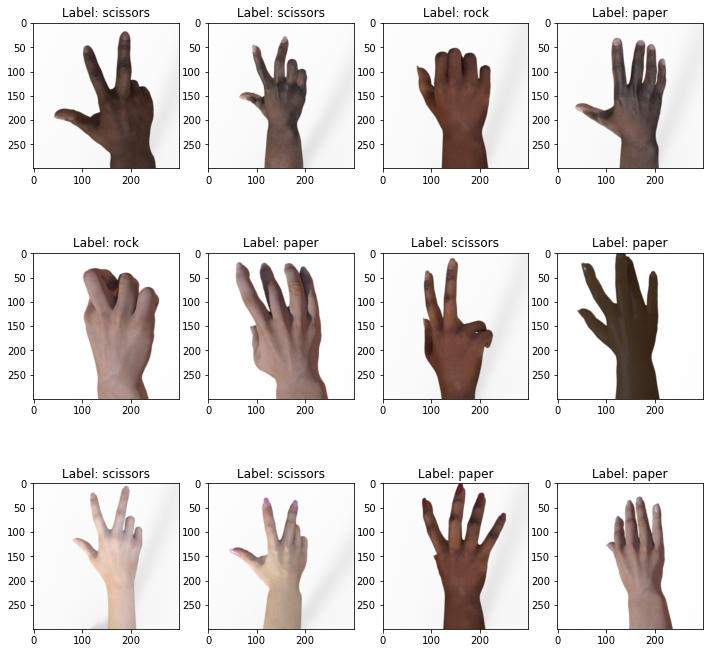

In [30]:
preview_dataset(dataset_train_raw)

In [35]:
def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize(image, [INPUT_IMG_SIZE, INPUT_IMG_SIZE])
    return image, label


In [39]:
dataset_train = dataset_train_raw.map(format_example)
dataset_test = dataset_test_raw.map(format_example)

In [83]:
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

In [84]:
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta = 0.08)
    image = tf.image.random_saturation(image, lower = 0.7, upper = 1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower = 0.8, upper = 1)
    image = tf.clip_by_value(image, clip_value_min = 0, clip_value_max = 1)
    return image

In [85]:
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    return tf.image.rot90(
        image,
        tf.random.uniform(shape = [], minval = 0, maxval = 4, dtype = tf.int32)
    )

In [101]:
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape = [], minval = 0, maxval = 1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

In [102]:
def augment_zoom(image: tf.Tensor) -> tf.Tensor:
    image_width, image_height, image_colors = image.shape
    crop_size = (image_width, image_height)
    
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))
    
    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]
        
    def random_crop(imageNested):
        crops = tf.image.crop_and_resize(
                [imageNested],
                boxes = boxes,
                box_indices = np.zeros(len(scales)),
                crop_size = crop_size
        )
        return crops[tf.random.uniform(shape = [], minval = 0, maxval = len(scales), dtype = tf.int32)]
    choice = tf.random.uniform(shape = [], minval = 0., maxval = 1., dtype = tf.float32)
    
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))
        

In [103]:
def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_inversion(image)
    image = augment_zoom(image)
    return image, label

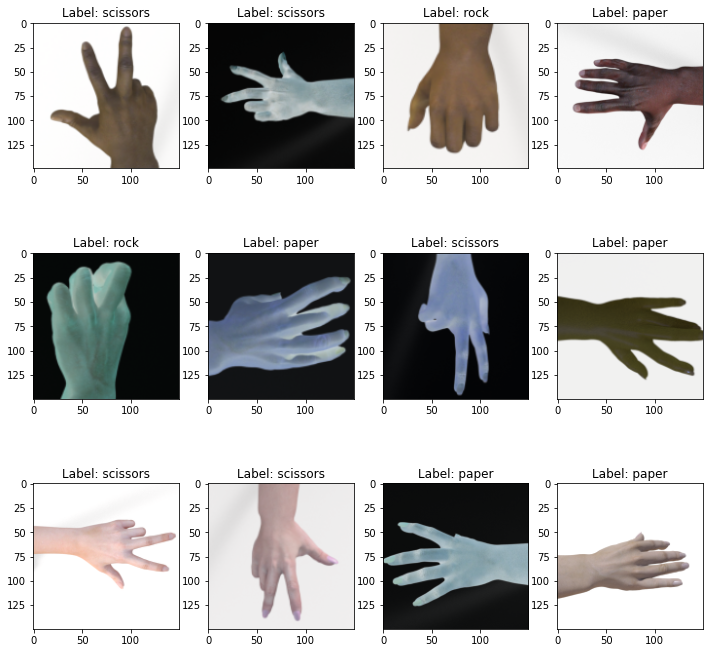

In [104]:
dataset_train_augmented = dataset_train.map(augment_data)
preview_dataset(dataset_train_augmented)

In [106]:
BATCH_SIZE = 32
dataset_train_augmented_shuffled = dataset_augmented.shuffle(
    buffer_size = NUM_TRAIN_EXAMPLES
)
dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.batch(
    batch_size = BATCH_SIZE
)

dataset_train_augmented_shuffled = dataset_train_augmented_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

dataset_test_shuffled = dataset_test.batch(BATCH_SIZE)

In [108]:
model = tf.keras.Sequential([
    # First convolition
    layers.Convolution2D(
        input_shape = INPUT_IMG_SHAPE,
        filters = 64,
        kernel_size = 3,
        activation = tf.keras.activations.relu
    ),
    
    layers.MaxPooling2D(
        pool_size = (2, 2),
        strides = (2, 2)
    ),
    
    # Second convolition
    layers.Convolution2D(
        input_shape = INPUT_IMG_SHAPE,
        filters = 64,
        kernel_size = 3,
        activation = tf.keras.activations.relu
    ),
    
    layers.MaxPooling2D(
        pool_size = (2, 2),
        strides = (2, 2)
    ),
    
    # Third convolition
    layers.Convolution2D(
        input_shape = INPUT_IMG_SHAPE,
        filters = 128,
        kernel_size = 3,
        activation = tf.keras.activations.relu
    ),
    
    layers.MaxPooling2D(
        pool_size = (2, 2),
        strides = (2, 2)
    ),
    
    # Forth convolition
    layers.Convolution2D(
        input_shape = INPUT_IMG_SHAPE,
        filters = 128,
        kernel_size = 3,
        activation = tf.keras.activations.relu
    ),
    
    layers.MaxPooling2D(
        pool_size = (2, 2),
        strides = (2, 2)
    ),
    
    # Flatten
    
    layers.Flatten(),
    layers.Dropout(0.5),
    
    layers.Dense(
        512, 
        activation = tf.keras.activations.relu
    ),
    
    layers.Dense(
        NUM_CLASSES,
        activation = tf.keras.activations.softmax
    )
    
])

In [109]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [113]:
rmsprop_optimizier = tf.keras.optimizers.RMSprop(learning_rate = 0.001)
model.compile(
    optimizer = rmsprop_optimizier,
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    metrics = ['accuracy']
)

In [115]:
steps_per_epoch = NUM_TRAIN_EXAMPLES // BATCH_SIZE
validation_steps = NUM_TEST_EXAMPLES // BATCH_SIZE

os.makedirs('logs/fits', exist_ok = True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy'
    # monitor='val_loss'
)

In [116]:
training_history = model.fit(
    x = dataset_train_augmented_shuffled.repeat(),
    validation_data = dataset_test_shuffled.repeat(),
    epochs = 20,
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    callbacks = [tensorboard_callback],
    verbose = 1
)

Epoch 1/20
 1/78 [..............................] - ETA: 0s - loss: 1.0826 - accuracy: 0.3125WARNING:tensorflow:From /Users/petrostepoyan/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


78/78 [==============================] - 50s 638ms/step - loss: 1.1037 - accuracy: 0.4808 - val_loss: 0.8268 - val_accuracy: 0.5824
Epoch 2/20
78/78 [==============================] - 54s 696ms/step - loss: 0.5708 - accuracy: 0.7818 - val_loss: 0.7298 - val_accuracy: 0.6591
Epoch 3/20
78/78 [==============================] - 58s 738ms/step - loss: 0.3477 - accuracy: 0.8738 - val_loss: 0.5738 - val_accuracy: 0.7614
Epoch 4/20
78/78 [==============================] - 56s 713ms/step - loss: 0.2558 - accuracy: 0.9059 - val_loss: 0.6849 - val_accuracy: 0.7585
Epoch 5/20
78/78 [==============================] - 55s 703ms/step - loss: 0.1784 - accuracy: 0.9361 - val_loss: 0.2704 - val_accuracy: 0.8977
Epoch 6/20
78/78 [==============================] - 54s 697ms/step - loss: 0.1460 - accuracy: 0.9506 - val_loss: 0.4539 - val_accuracy: 0.7443
Epoch 7/20
78/78 [==============================] - 64s 822ms/step - loss: 0.1169 - accuracy: 0.9638 - val_loss: 0.7627 - val_accuracy: 0.7244
Epoch 8/20

In [117]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

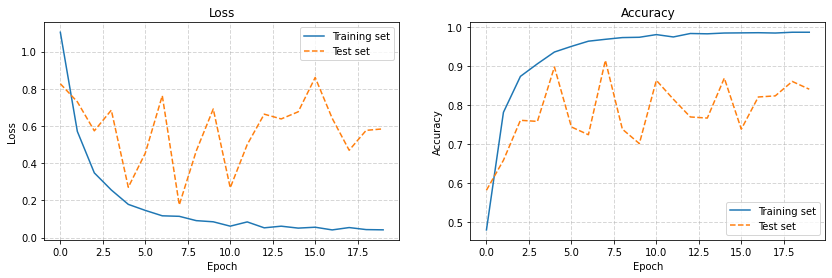

In [118]:
render_training_history(training_history)

In [12]:
model_name = "RPS_classifier"
model.save(model_name, save_format='h5')

In [13]:
import coremltools as ct

def convert2mlmodel(model_name):

    model = tf.keras.models.load_model(model_name)
    classifier_config = ct.ClassifierConfig(["rock", "paper", "scissors"])

    mlmodel = ct.convert(model,
                         inputs = [ct.ImageType()],
                         classifier_config = classifier_config)

    # Set model author name
    mlmodel.author = 'Petros Tepoyan'

    # Set the license of the model
    mlmodel.license = "Will add repo later"

    # Set a short description for the Xcode UI
    mlmodel.short_description = "Detects whether a human showed rock, paper, or scissors"

    # Set a version for the model
    mlmodel.version = "1.0"

Translating MIL ==> MLModel Ops: 100%|██████████| 69/69 [00:00<00:00, 163.86 ops/s]


In [54]:
from PIL import Image
example_image = Image.open("testImages/paper.png").resize((150, 150))
image = np.array(example_image)[..., :3]
model.predict([image.reshape((1, 150, 150, 3))])


array([[1., 0., 0.]], dtype=float32)

In [55]:
example_image = Image.open("testImages/paper.png").resize((150, 150))
image = np.array(example_image)[..., :3]
model.predict([image.reshape((1, 150, 150, 3))])

array([[1., 0., 0.]], dtype=float32)

In [56]:
example_image = Image.open("testImages/scissors.png").resize((150, 150))
image = np.array(example_image)[..., :3]
model.predict([image.reshape((1, 150, 150, 3))])

array([[0., 1., 0.]], dtype=float32)

In [27]:
mlmodel.save("RPS_classifier")

In [ ]:
model 